In [1]:
import os
# set the appropriate path to whichever R installation we'd like to use
os.environ['R_HOME'] = '/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/R'
import rpy2
import sys
sys.path.append('../')
from fnc_analysis import *
from scipy import stats as st
from statsmodels.stats.multitest import multipletests
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg
from pathlib import Path
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
# figure settings
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['font.size']= 8
ctl_col = '#D4D4D4'
stim_col = '#06e1e9'

In [3]:
# load tidy data and subset dataframes for later use
data_dir = "../../../data/behavior"

#load unlimited intake
df = load_data(os.path.join(data_dir,'unlimited_intake/total_licks_normal_intake.csv'))
dft = load_data(os.path.join(data_dir,'unlimited_intake/lick_times_normal_intake.csv'))

#load limited intake
df_ltd = load_data(os.path.join(data_dir,'limited_intake/total_licks_limited_intake.csv'))
dft_ltd = load_data(os.path.join(data_dir,'limited_intake/lick_times_limited_intake.csv'))

#load extinction
df_ex = load_data(os.path.join(data_dir,'extinction3/total_licks_extinction3.csv'))
dft_ex = load_data(os.path.join(data_dir,'extinction3/lick_times_extinction3.csv'))

#load extinction pt2
df_ex2 = load_data(os.path.join(data_dir,'extinction4/total_licks_extinction4.csv'))
dft_ex2 = load_data(os.path.join(data_dir,'extinction4/lick_times_extinction4.csv'))


#select glucose data
#unlimited intake
df_test_g = subset_df(df, 'test')
dft_test_g = subset_df(dft, 'test')

df_train_g = subset_df(df, 'training')
dft_train_g = subset_df(dft, 'training')


#limited intake
df_test_g_ltd = subset_df(df_ltd, 'test')
dft_test_g_ltd = subset_df(dft_ltd, 'test')

df_train_g_ltd = subset_df(df_ltd, 'training')
dft_train_g_ltd = subset_df(dft_ltd, 'training')


#extinction
df_test_g_ex = subset_df(df_ex, 'test') 
dft_test_g_ex = subset_df(dft_ex, 'test') 

df_train_g_ex = subset_df(df_ex, 'training') 
dft_train_g_ex = subset_df(dft_ex, 'training') 

#extinction 2
df_test_g_ex2 = subset_df(df_ex2, 'test')
dft_test_g_ex2 = subset_df(dft_ex2, 'test')

df_train_g_ex2 = subset_df(df_ex2, 'training')
dft_train_g_ex2 = subset_df(dft_ex2, 'training')

#combine
df_test_g_ltd_cohort = pd.concat({0: df_test_g_ltd, 
                                  1: df_test_g_ex.loc[:,:,:1], 
                                  2: df_test_g_ex2.loc[:,:,:1]}, 
                                 names=['cohort'])
df_test_g_ltd = df_test_g_ltd_cohort.droplevel('cohort').sort_index()

dft_test_g_ltd_cohort = pd.concat({0: dft_test_g_ltd, 
                                   1: dft_test_g_ex.loc[:,:,:1], 
                                   2: dft_test_g_ex2.loc[:,:,:1]}, 
                                  names=['cohort'])
dft_test_g_ltd = dft_test_g_ltd_cohort.droplevel('cohort').sort_index()


df_train_g_ltd_cohort = pd.concat({0: df_train_g_ltd, 
                                   1: df_train_g_ex, 
                                   2: df_train_g_ex2}, 
                                  names=['cohort'])
df_train_g_ltd = df_train_g_ltd_cohort.droplevel('cohort').sort_index()


dft_train_g_ltd_cohort = pd.concat({0: dft_train_g_ltd, 
                                    1: dft_train_g_ex, 
                                    2: dft_train_g_ex2}, 
                                   names=['cohort'])
dft_train_g_ltd = dft_train_g_ltd_cohort.droplevel('cohort').sort_index()

## validation of limited intake during training

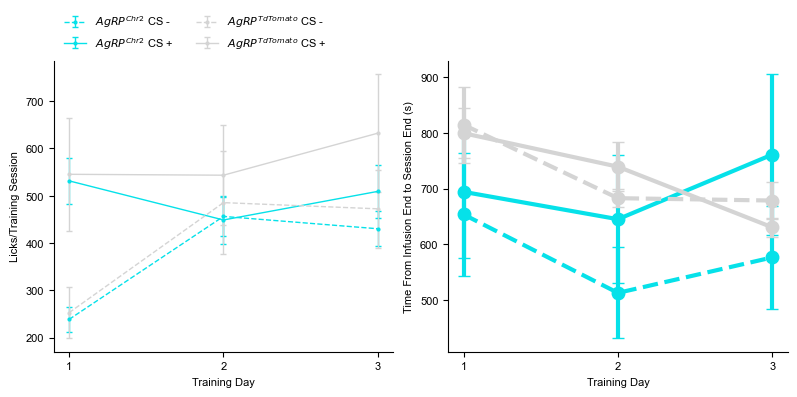

In [4]:
# create subplots
fig, ax = plt.subplots(1,2, figsize = (8,4))

# plot training licks
training_plot(df_train_g_ltd.sort_index().loc[True,], df_train_g_ltd.sort_index().loc[False,], 
              colors = [stim_col, ctl_col], ax = ax[0]);

# validate that controls and stim mice had bottles for equivalent amounts of time
_, s, c = plot_t_to_end(dft_train_g_ltd.sort_index().loc[True,],dft_train_g_ltd.sort_index().loc[False,],
              colors = [stim_col, ctl_col], ax = ax[1]);
tend = pd.concat({True: s, False: c}, names = ["Chr2"])



# remove extra legends
ax[1].get_legend().remove()


#format the figure
fig.tight_layout(pad = 1.)

#### stats

##### stats - limited intake validation of equal training licks

In [5]:
ltd_val = (df_train_g_ltd.groupby(['day','CS'])
                         .total_licks
                         .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = True))
                         .apply(lambda x: pd.Series(x, index = ('statistic', 'pvalue'))))
ltd_val['pvalue_corr'] = multipletests(ltd_val.pvalue, method = 'holm-sidak')[1]

print('glucose')
display(ltd_val)

glucose


statistic    pvalue  pvalue_corr
day CS                                  
0   +   -0.105217  0.916804     0.993007
    -   -0.230021  0.819415     0.993007
1   +   -0.795754  0.431539     0.945466
    -   -0.243852  0.808769     0.993007
2   +   -0.881253  0.384193     0.945466
    -   -0.457561  0.650096     0.985010

##### stats - limited intake validation of equal time to end

In [6]:
tend_val = (tend.groupby(['day','CS'])
                .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = True))
                .apply(lambda x: pd.Series(x, index = ('statistic', 'pvalue'))))
tend_val['pvalue_corr'] = multipletests(tend_val.pvalue, method = 'holm-sidak')[1]

print('glucose')
display(tend_val)

glucose


statistic    pvalue  pvalue_corr
day CS                                  
0   +   -0.841487  0.405788     0.753946
    -   -1.252064  0.218849     0.709146
1   +   -0.781292  0.439884     0.753946
    -   -2.092926  0.043672     0.235035
2   +    0.922943  0.362356     0.753946
    -   -1.061572  0.295700     0.753946

## comparing control two bottle test performance limited vs unlimited


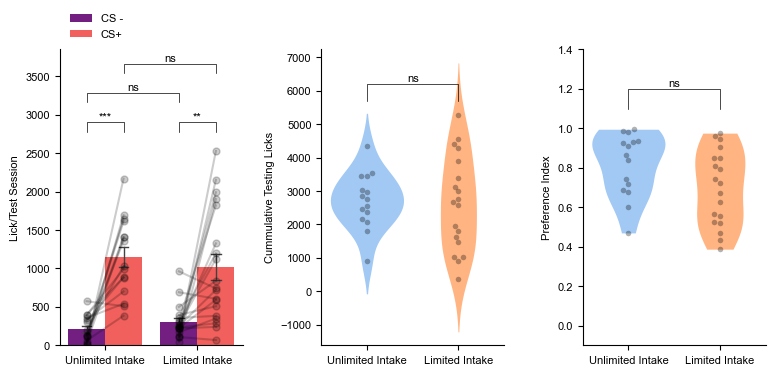

In [7]:
# glucose
normal_ctl = average_test_data(df_test_g, Chr2=False)
ltd_ctl = average_test_data(df_test_g_ltd, Chr2=False)

fig, ax = plt.subplots(1,3, figsize=(8,4))

# plot mean cs+ and cs- testing licks
_, stat_ltd_unltd_g = two_bottle_plot(ltd_ctl, normal_ctl,  ax=ax[0],
                                      groups= ['Limited Intake', 'Unlimited Intake']);
# plot cummulative testing licks
_, stat_ltd_unltd_tot_g = cumm_test_licks_plot(df_test_g_ltd.loc[False,], df_test_g.loc[False,] ,
                                               groups= ['Limited Intake', 'Unlimited Intake'], 
                                               ax=ax[1], palette= sns.color_palette('pastel',2)[::-1])
# plot lick preference index
_, _, stat_ltd_unltd_pref_g = two_bottle_pref_plot_vl(df_test_g_ltd.loc[False,], df_test_g.loc[False,] ,
                                                      groups= ['Limited Intake', 'Unlimited Intake'], 
                                                      ax=ax[2], palette= sns.color_palette('pastel',2)[::-1]);

    
# format plots
fig.tight_layout(pad=2.0)

#### stats

##### stats - glucose unlimited vs limited mean CS+ and CS- licks

In [8]:
df = pd.concat({True: df_test_g_ltd.loc[False,], 
                False: df_test_g.loc[False,]},
               names = ["limited"]).groupby(['limited','mouse','CS']).mean().reset_index()
shapiro = (df.groupby(['limited','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.limited].total_licks, x.loc[~x.limited].total_licks), index = ('statistic', 'p-value')))
          )
anova_res = pg.mixed_anova(data = df, within = 'CS', between = 'limited', dv = 'total_licks', subject = 'mouse')


/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_30715/679314846.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  names = ["limited"]).groupby(['limited','mouse','CS']).mean().reset_index()


##### stats - unlimited vs limited cummulative licks

In [9]:
stat_ltd_unltd_tot_g_df = pd.DataFrame({'ttest': stat_ltd_unltd_tot_g}, index = ['statistic', 'pvalue', 'df']).T

print('glucose')
display(stat_ltd_unltd_tot_g_df)

glucose


,statistic,pvalue,df
ttest,-0.194396,0.84718,32.0


##### stats - unlimited vs limited pref

In [10]:
stat_ltd_unltd_pref_g_df = pd.DataFrame({'ttest': stat_ltd_unltd_pref_g}, index = ['statistic', 'pvalue']).T


print('glucose')
display(stat_ltd_unltd_pref_g_df)

glucose


,statistic,pvalue
ttest,89.0,0.066022
